# Week 10

This week covers part of speech tagging in more detail.

Overview

* [**Tagging and Tagsets**](#Tagging-and-Tagsets)
* [**Heuristic-based Tagging**](#Heuristic-based-Tagging)
* [**N-Gram Tagging**](#N-Gram-Tagging)
* [**Visualizing Errors**](#Visualizing-Errors)
* [**State-of-the-art Taggers**](#State-of-the-art-Taggers)

In [3]:
# First import some things to work with

import nltk
from nltk.corpus import brown

# nltk.download('brown')
# nltk.download('punkt')

brown_tagged_news = brown.tagged_sents(categories='news')
brown_news = brown.sents(categories='news')
brown_tagged_scifi = brown.tagged_sents(categories='science_fiction')
brown_scifi = brown.sents(categories='science_fiction')

sent = nltk.word_tokenize('From each according to their ability, to each according to their need.')
sent

['From',
 'each',
 'according',
 'to',
 'their',
 'ability',
 ',',
 'to',
 'each',
 'according',
 'to',
 'their',
 'need',
 '.']

# Tagging and Tagsets

Recall that part-of-speech tagging assigns a word category to each token in a sentence:

In [4]:
nltk.pos_tag(sent)

[('From', 'IN'),
 ('each', 'DT'),
 ('according', 'VBG'),
 ('to', 'TO'),
 ('their', 'PRP$'),
 ('ability', 'NN'),
 (',', ','),
 ('to', 'TO'),
 ('each', 'DT'),
 ('according', 'VBG'),
 ('to', 'TO'),
 ('their', 'PRP$'),
 ('need', 'NN'),
 ('.', '.')]

The categories are defined by **tagsets**. The example above uses the English Penn Treebank tagset, but others are available, even cross-lingual sets. Part-of-speech tagging isn't just for words, but also punctuation and sometimes parts of words. For example, the [Mecab](https://taku910.github.io/mecab/) morphological analyzer for Japanese does both word segmentation and tagging, and morphological segments get their own tag (note: this is shown executed in a terminal, not Python):

```bash
$ mecab -Osimple <<< "能力に応じて働き、必要に応じて受け取る。"
能力	名詞-一般
に	助詞-格助詞-一般
応じ	動詞-自立
て	助詞-接続助詞
働き	動詞-自立
、	記号-読点
必要	名詞-形容動詞語幹
に	助詞-副詞化
応じ	動詞-自立
て	助詞-接続助詞
受け取る	動詞-自立
。	記号-句点
EOS
```

## Heuristic-based Tagging

A simple way to tag is to use basic statistics or language knowledge to create a tagger with hand-built rules.


### Default Tagger

The default tagger assigns the same tag to all tokens. This is useless for general purpose uses, but it is useful for establishing baseline performance.

In [5]:
nn_tagger = nltk.DefaultTagger('NN')
nn_tagger.tag(sent)

[('From', 'NN'),
 ('each', 'NN'),
 ('according', 'NN'),
 ('to', 'NN'),
 ('their', 'NN'),
 ('ability', 'NN'),
 (',', 'NN'),
 ('to', 'NN'),
 ('each', 'NN'),
 ('according', 'NN'),
 ('to', 'NN'),
 ('their', 'NN'),
 ('need', 'NN'),
 ('.', 'NN')]

In [6]:
nn_tagger.evaluate(brown_tagged_news)

0.13089484257215028

In [7]:
nn_tagger.evaluate(brown_tagged_scifi)

0.10649619903248099

Why choose `NN`?

In [8]:
fd = nltk.FreqDist(tag for sent in brown_tagged_news for _, tag in sent)
fd.most_common(20)

[('NN', 13162),
 ('IN', 10616),
 ('AT', 8893),
 ('NP', 6866),
 (',', 5133),
 ('NNS', 5066),
 ('.', 4452),
 ('JJ', 4392),
 ('CC', 2664),
 ('VBD', 2524),
 ('NN-TL', 2486),
 ('VB', 2440),
 ('VBN', 2269),
 ('RB', 2166),
 ('CD', 2020),
 ('CS', 1509),
 ('VBG', 1398),
 ('TO', 1237),
 ('PPS', 1056),
 ('PP$', 1051)]

#### TODO: try using a different default tag and evaluate it

In [10]:
nn_tagger = nltk.DefaultTagger('VBN')
nn_tagger.tag(sent)

[('From', 'VBN'),
 ('each', 'VBN'),
 ('according', 'VBN'),
 ('to', 'VBN'),
 ('their', 'VBN'),
 ('ability', 'VBN'),
 (',', 'VBN'),
 ('to', 'VBN'),
 ('each', 'VBN'),
 ('according', 'VBN'),
 ('to', 'VBN'),
 ('their', 'VBN'),
 ('need', 'VBN'),
 ('.', 'VBN')]

In [11]:
nn_tagger.evaluate(brown_tagged_news)

0.022564989955645723

## Pattern-based Tagging

With a bit more information about the forms of the words, the tagger can do better:

In [37]:
regexp_tagger = nltk.RegexpTagger(
    [(r'^\.$', '.'),
     (r'^,$', ','),
     (r'.*ful$', 'JJ'),
     (r'^un', 'JJ'),
     (r'.*ly$', 'RB'),
     (r'.*ing$', 'VBG'),                # gerunds
     (r'.*ed$', 'VBD'),                 # simple past
     (r'.*es$', 'VBZ'),                 # 3rd singular present
     (r'.*ould$', 'MD'),                # modals
     (r'.*\'s$', 'NN$'),                # possessive nouns
     (r'.*s$', 'NNS'),                  # plural nouns
     (r'^-?[0-9]+(\.[0-9]+)?$', 'CD'),  # cardinal numbers
     (r'.*', 'NN')                      # nouns (default)
    ])
regexp_tagger.tag(sent)

[('From', 'NN'),
 ('each', 'NN'),
 ('according', 'VBG'),
 ('to', 'NN'),
 ('their', 'NN'),
 ('ability', 'NN'),
 (',', ','),
 ('to', 'NN'),
 ('each', 'NN'),
 ('according', 'VBG'),
 ('to', 'NN'),
 ('their', 'NN'),
 ('need', 'VBD'),
 ('.', '.')]

In [38]:
regexp_tagger.evaluate(brown_tagged_news)

0.2992322533166259

In [39]:
regexp_tagger.evaluate(brown_tagged_scifi)

0.29108500345542504

#### TODO: try adding some more rules, or rearranging them, to improve performance

In [ ]:
regexp_tagger2 = nltk.RegexpTagger(
    [(r'.*ing$', 'VBG'),                # gerunds
     (r'.*ed$', 'VBD'),                 # simple past
     (r'.*es$', 'VBZ'),                 # 3rd singular present
     (r'.*ould$', 'MD'),                # modals
     (r'.*\'s$', 'NN$'),                # possessive nouns
     (r'.*s$', 'NNS'),                  # plural nouns
     (r'^-?[0-9]+(\.[0-9]+)?$', 'CD'),  # cardinal numbers
     (r'.*', 'NN')                      # nouns (default)
    ])
regexp_tagger2.tag(sent)     

In [ ]:
regexp_tagger2.evaluate(brown_tagged_news)

In [ ]:
regexp_tagger2.evaluate(brown_tagged_scifi)

## N-Gram Tagging

Rather than trying to hand-build many rules to cover all of a language, we can **train** a tagger to **learn** the best tags for each word. This uses statistical inference based on hand-tagged (gold) data, which we assume is correct.

### Unigram Tagging

First we will start by assigning the tag most frequently associated with a particular word form for the 100 most frequent words (all other words get a tag of `None`):

In [51]:
# TODO: find the N most frequent words in the Brown corpus's "news" category 
N = 100

words = []
for sent in brown_news:
    words.extend(sent)
nltk.FreqDist(words)

fd = nltk.FreqDist(w for sent in brown_news for w in sent)

fd.most_common(N)
# TODO: find the most likely tags for those words (create a dict mapping {word: tag})
cfd = nltk.ConditionalFreqDist(
    (word, tag)
    for tsent in brown_tagged_news
    for (word, tag) in tsent
)
model = {}
for word, freq in fd.most_common(N):
    tag = cfd[word].max()
    model[word] = tag
#model

In [55]:
# TODO: build a UnigramTagger using the most likely tags as a model
baseline_tagger = nltk.UnigramTagger(model=model)

#### TODO: evaluate this tagger on the news and scifi data

In [56]:
baseline_tagger.evaluate(brown_tagged_news)

0.45578495136941344

#### TODO: increase `N`, then retrain, then re-evaluate

In [62]:
N = 100000
model = {}
for word, freq in fd.most_common(N):
    tag = cfd[word].max()
    model[word] = tag
baseline_tagger = nltk.UnigramTagger(model=model)
baseline_tagger.evaluate(brown_tagged_news)

0.9349006503968017

In [63]:
unitagger = nltk.UnigramTagger(brown_tagged_news)
unitagger.evaluate(brown_tagged_news)

0.9349006503968017

### Bigram and Trigram Tagging

Now let's give the model a bit of context by using bigrams.

In [64]:
bigram_tagger = nltk.BigramTagger(brown_tagged_news)
bigram_tagger.tag(sent)

[('This', 'DT'),
 ('is', 'BEZ'),
 ('one', 'CD'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('main', 'JJS'),
 ('reasons', 'NNS'),
 ('for', 'IN'),
 ('National', 'JJ-TL'),
 ('Library', 'NN-TL'),
 ('Week', 'NN-TL'),
 (',', ','),
 ('April', 'NP'),
 ('16-22', 'CD'),
 (',', ','),
 ('and', 'CC'),
 ('for', 'IN'),
 ('its', 'PP$'),
 ('theme', 'NN'),
 (':', ':'),
 ('``', '``'),
 ('For', 'IN'),
 ('a', 'AT'),
 ('richer', 'JJR'),
 (',', ','),
 ('fuller', 'JJR'),
 ('life', 'NN'),
 (',', ','),
 ('read', 'VBD'),
 ("''", "''"),
 ('!', '.'),
 ('!', '.')]

In [65]:
bigram_tagger.evaluate(brown_tagged_news)

0.7892972929967977

In [66]:
bigram_tagger.evaluate(brown_tagged_scifi)

0.14948168624740843

In [67]:
trigram_tagger = nltk.TrigramTagger(brown_tagged_news)
trigram_tagger.evaluate(brown_tagged_news)

0.8198679316586113

Did the accuracy go up with more n-grams? Try using a backoff and try again:

In [69]:
bigram_tagger = nltk.BigramTagger(brown_tagged_news, backoff=unitagger)
bigram_tagger.evaluate(brown_tagged_news)

0.9731487558923564

In [71]:
trigram_tagger = nltk.TrigramTagger(brown_tagged_news, backoff=bigram_tagger)
trigram_tagger.evaluate(brown_tagged_news)

0.9826759750979573

In [72]:
trigram_tagger.evaluate(brown_tagged_scifi)

0.8101589495507947

## K-fold Cross-validation

Split the training data (`brown_tagged_news` or `brown_tagged_scifi`) for k-fold cross validation. For some value `k` (say, 5), set aside `1/k` for test data and the remainder for training data. Train a bigram tagger with backoff on the training data, then evaluate on the test data.

```
 12345                       25
|.....|.....|.....|.....|.....|

i = 0
test = [0:5]
train = [5:len(data)]

i = 1
test = [5:10]
train = [0:5] + [10:len(data)]
```

In [77]:
news = brown_tagged_news
print(924 * 5)

print(len(news))
k = 5
index = int( (1/k) * len(brown_tagged_news) )
accs = []

for i in range(k):
    # TODO: extract 1/k of the data for testing
    # TODO: extract (k-1)/k of the data for training
    # (hint, use 'index' and 'i' to find where to split)
    test_data = news[(i*index):((i+1)*index)]
    train_data = news[:i*index] + news[(i+1)*index:]

    # TODO: create a bigram tagger that backs off to a unigram tagger
    # trained using the extracted training data
    unigram_tagger = nltk.UnigramTagger(train_data, backoff=regexp_tagger)
    bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
    # TODO: now evaluate on the test data
    acc = bigram_tagger.evaluate(test_data)
    print(f'i={i}, accuracy={acc}')
    accs.append(acc)
print('average accuracy', sum(accs)/k)  # print the average

4620
4623
i=0, accuracy=0.8732525173526249
i=1, accuracy=0.8319489149621015
i=2, accuracy=0.8479944053149508
i=3, accuracy=0.8578222778473091
i=4, accuracy=0.8615525378021767
average accuracy 0.8545141306558326


## Visualizing Errors

In [78]:
auto_tagged = bigram_tagger.tag(brown.words(categories='news'))
hand_tagged = brown.tagged_words(categories='news')
assert len(auto_tagged) == len(hand_tagged)

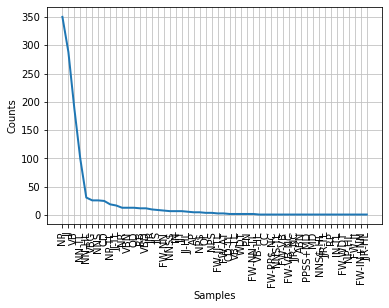

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [79]:
%matplotlib inline

t2t_cfd = nltk.ConditionalFreqDist(
    (t1[1], t2[1])
    for t1, t2 in zip(auto_tagged, hand_tagged)
    if t1[1] != t2[1])
t2t_cfd['NN'].plot()

## State-of-the-art Taggers

The http://nlpprogress.com/ website tracks the start-of-the-art (SOTA) performance of many different NLP tasks. For part of speech tagging (http://nlpprogress.com/english/part-of-speech_tagging.html), the top systems get over 97% accuracy. 